# Activity 6.2 Linear Regression in Spark
In this activity we implement a basic linear regression using Map-Reduce and run it on Spark. From Chapter 6.2 recall that the calculation of the gradient is the computation intensive part of batch gradient descent for linear regression models. Fortunately, we can paralelalise this part of the algorithm to achinve a better performance (in terms of computation time).

**Note:** This activity is developed based on:
https://github.com/apache/spark/blob/master/examples/src/main/python/logistic_regression.py

In [2]:
import matplotlib.pyplot as plt
import numpy as np # numpy provides lots of math functions
from __future__ import print_function
from pyspark import SparkContext

## Auxiliary Functions
Let's start with defining some auxiliray functions to make our code clean and clear. The first function is the `add` function that we will use it in the `reduce` method. 

In [3]:
# add function!
def add(x,y): return x + y

This is the `readPointBatch` fucntion  that will be used as a partition mapper. Indeed, `readPointBatch` maps the text partitions, that were produced by `textFile` function,  into partitions contatining a chunk of the data matrix (i.e., batches of float numbers). To be able to implement our algorithm using Spark features, the data has to be in certain format. For example, in this activity we assume that our data is space ' ' separated and stored in $<label> <x_1> <x_2> \dots <x_D>$ format ($D$ is number of dimensions and $label$ is numeric).

In [4]:
# the following function converts the content of the file to an specific convention (will be discussed)
# it also partitiones data to some batches
def readPointBatch(iterator,D):
    strs = list(iterator)
    matrix = np.zeros((len(strs), D + 1))
    for i, s in enumerate(strs):
        matrix[i] = np.fromstring(s.replace(',', ' '), dtype=np.float32, sep=' ')
    return [matrix]

Here we implement a simple function that will be helpfull in counting the number of datapoints.

In [5]:
# Returns the number of points in a matrix
def num_points(matrix):
    return np.size(matrix,1)

Now, let us define the  `gradient` and `error` functions. They get data as `matrix` and weight vector `w`, and then compute the gradeint and the error according to the given weight vector. We will use these functions in the body of our linear regression code.

In [6]:
# Computes linear regression gradient for a matrix of data points
def gradient(matrix, w):
    T = matrix[:, 0]    # point labels (first column of input file)
    X = matrix[:, 1:]   # point coordinates
    X = np.concatenate((X, np.ones((np.size(X,0),1))), axis=1) # add a column of all 1 (for intercept)
    # For each point (x, y), compute gradient function, then sum these up
    return (-(T-X.dot(w)) * X.T).sum(1)

# Computes the training error of the given data (matrix)
def error(matrix, w):
    T = matrix[:, 0]    # point labels (first column of input file)
    X = matrix[:, 1:]   # point coordinates
    X = np.concatenate((X, np.ones((np.size(X,0),1))), axis=1) # add a column of all 1 (for intercept)
    # For each point (x, y), compute gradient function, then sum these up
    return ((T-X.dot(w))**2).sum(0)


## Data
Here, we create an Spark Context object, then read `LR_small.csv` file and slipt it into some partitions using `textFile` function.

In [7]:
# Initiate Spark
sc.stop()  # just in case there is a crashed/running context!
sc = SparkContext() # initiate an new context
# Read and distribute the file 
points = sc.textFile("./LR_small.csv")
# in case you want to take a look at the data (each line contains 1 target and 10 predictor values)
!head ./LR_all.csv 

Now, we need to convert the text strings into matrices using `readPointBatch` function. Note that each partition of the input text should be convereted to a single matrix (that's why we use `mapPartitions`). When the convertion is done, we store the matrices in cashe for future uses.

In [8]:
D = 10   # Number of dimensions.
# read batch of points and store in cache
points = points.mapPartitions(lambda j: readPointBatch(j,D)).cache() 

## Linear Regression
The follwoing is our Linear Regression implementation using Spark. Let's start with the initializations.

In [9]:
# initalizations:
N = points.map(lambda m: num_points(m)).reduce(add)
iterations = 500 # linear regression maximum iterations
errors = np.zeros((iterations+1, 1))
weights = np.zeros((iterations+1, D + 1))
eta = 0.0001 # initial value for learning rate
w = 2 * np.random.ranf(size=(D+1)) - 1 # Initialize w to random values [-1,1]

Now, we can run the main loop. The key line in this loop is `w -= points.map(lambda m: gradient(m, w)).reduce(add) * eta` which updates the weight vector `w` based on the sum of the gradeints (multiplied by the learning rate `eta`). 

In [10]:
# Linear Regression MAIN loop
for i in range(iterations):
    # keep the record of errors
    errors[i, 0] = (points.map(lambda m: error(m, w)).reduce(add))**(0.5)/N
    # keep the record of weights
    weights[i,:] = w
    # display the progress every 10 iterations
    if i%10 ==0:
        print("On iteration %i Error: %f" % (i + 1,  errors[i,0]))
    # calculate the new weights
    w -= points.map(lambda m: gradient(m, w)).reduce(add) * eta # map & reduce!
    # decrease the learning rate (for convergence)
    eta = eta * 0.9999

On iteration 1 Error: 14.333726
On iteration 11 Error: 12.890932
On iteration 21 Error: 11.646359
On iteration 31 Error: 10.572582
On iteration 41 Error: 9.646236
On iteration 51 Error: 8.847354
On iteration 61 Error: 8.158821
On iteration 71 Error: 7.565912
On iteration 81 Error: 7.055906
On iteration 91 Error: 6.617776
On iteration 101 Error: 6.241927
On iteration 111 Error: 5.919986
On iteration 121 Error: 5.644637
On iteration 131 Error: 5.409479
On iteration 141 Error: 5.208916
On iteration 151 Error: 5.038066
On iteration 161 Error: 4.892673
On iteration 171 Error: 4.769046
On iteration 181 Error: 4.663990
On iteration 191 Error: 4.574748
On iteration 201 Error: 4.498955
On iteration 211 Error: 4.434582
On iteration 221 Error: 4.379899
On iteration 231 Error: 4.333432
On iteration 241 Error: 4.293927
On iteration 251 Error: 4.260322
On iteration 261 Error: 4.231715
On iteration 271 Error: 4.207346
On iteration 281 Error: 4.186568
On iteration 291 Error: 4.168837
On iteration 301 

Done! Let's see the final weights and error....

In [11]:
errors[-1, 0] = (points.map(lambda m: error(m, w)).reduce(add))**(0.5)/N
weights[-1,:] = w

print("Final w: " + str(w))
print("Final error: " + str((points.map(lambda m: error(m, w)).reduce(add))**(0.5)/N))
sc.stop()

Final w: [  1.1868586    2.09777429   0.25298232   2.4092738    2.92885362
   2.02913539   2.16060976   0.61416484   1.54842508   2.03867811
  28.84178787]
Final error: 4.06602861095


... and draw the convergence plot.

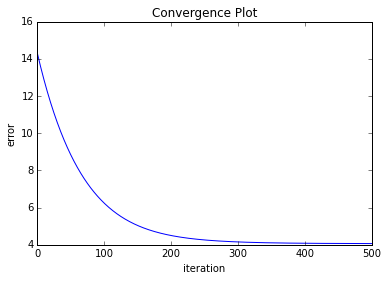

In [12]:
%matplotlib inline
plt.plot(errors)
plt.title('Convergence Plot')
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

## Discussions